# Notes
- Different species
- Gap phase replacement
- Spatial field

# To-do
- Inform initial spatial and size distributions
- Inform reproductive mechanism (range, probability, etc.)
- Inform mortality mechanism
- Make the viewer more interactive (zoom and move around, play, reverse, speed up, slow down)
- ~~Write your own quadtree class and add a method for removing objects from it to speed up collision detection~~
- ~~Implement plant reproduction (either as a method in the Plant class or in the Simulation class)~~
- ~~Fix new plant spawns showing up for one frame and then getting killed~~
- ~~Add find collisions to Simulation class~~
- ~~Move plants list and states list to Simulation class~~
- ~~Fix Plant .kill() method~~
- ~~replace .update_color() method to set_color() in Plant class~~
- ~~add simulation.step() method to Simulation class~~

### Units
We want to ensure that the initial area per plant is constant regardless of how many plants we start with. Our simulation domain in our arbitrary units ($u$) has an area of
$$A_\mathrm{sim} = Y \,u^2,$$
where $Y$ is a floating point number. Now, if we want $X$ $\mathrm{m}^2$ per plant, and we have $N$ plants that gives a total area of
$$A_\mathrm{real} = N X \,\mathrm{m}^2,$$
where $N$ is an integer and $X$ is a floating point number. Thus the conversion factor from our arbitrary units $u$ to meters $\mathrm{m}$ can be obtained
$$\begin{align}
1 = \frac{A_\mathrm{sim}}{A_\mathrm{real}} &= \frac{Y}{N X}\frac{u^2}{\mathrm{m}^2}\\
\frac{\mathrm{m}}{u} &= \sqrt{\frac{Y}{NX}}.
\end{align}$$

If we for example have a domain with area $A_\mathrm{sim} = Y \, u^2 = 1 \, u^2$ and we have $N = 10\,000$ plants which each with $X = 100 \, \mathrm{m^2}$ allocated, we get a conversion factor of
$$\begin{align}
    1 \, \mathrm{m} = \sqrt{\frac{1}{10\,000 \cdot 100}} \, u = \sqrt{10^{-6}} = 10^{-3} \, u
\end{align}$$

# Intersection probability
### Probability of a Point Inside Circles in a Square
**Problem Setup**
- Square with side length $S$
- $N$ circles with radii uniformly distributed between $r_{min}$ and $r_{max}$
- Find the probability that a new random point $p$ is inside at least one circle

**1. Expected Area of a Single Circle**

$$E[A] = \pi E[r^2] = \pi(r_{min}^2 + r_{max}^2 + r_{min}r_{max}) / 3$$

**2. Total Expected Area Covered by Circles**

$$E[A_\mathrm{total}] = N \cdot E[A]$$

**3. Probability Calculation**

The probability of the point being inside a circle is equal to the fraction of the square's area that is covered by circles, on average:

$$P(p \text{ inside at least one circle}) = \frac{E[A_\mathrm{total}]}{S^2} = \frac{N \cdot \pi \cdot (r_{min}^2 + r_{max}^2 + r_{min}r_{max})}{3S^2}$$

**4. Edge Cases**

- If $E[A_\mathrm{total}] > S^2$, cap the probability at 1
- The formula assumes circles can overlap and extend beyond the square's boundaries

## Notes

This approach uses the concept of expected value and assumes that the circles are placed randomly and independently. It's an average case analysis - the actual probability for a specific configuration of circles might differ.

For very large $N$ or when circles are large relative to the square, this simple formula might overestimate the probability due to increased overlap. In such cases, more sophisticated models from continuum percolation theory might be needed.

## Key Reference

Hall, P. (1988). Introduction to the Theory of Coverage Processes. John Wiley & Sons.

This book discusses various aspects of coverage problems, including the one we've just solved.



*WRITTEN BY CLAUDE AI*

**Define the problem parameters.**
- Square side length: $S$
- Number of circles: $N$
- Distribution of circle radii: Let's assume a uniform distribution between $r_\mathrm{min}$ and $r_\mathrm{max}$ for simplicity


**Expected area of a single circle.**
$$E[A] = \pi \cdot E[r^2]$$
For a uniform distribution: $E[r^2] = (r_\mathrm{min}^2 + r_\mathrm{max}^2 + r_\mathrm{min}r_\mathrm{max}) / 3$


**Total expected area covered by all circles.**
$$E[A_\mathrm{total}] = N \cdot E[A]$$

**Probability of a random point being covered by at least one circle**
$$P(\mathrm{covered}) = 1 - \exp\left(-\frac{E[A_\mathrm{total}]}{S^2}\right)$$

This step uses the void (avoidance) probability from the Boolean model in stochastic geometry. The $\exp(-\mathrm{density})$ term gives the probability of a point not being covered by any circle (which is exactly the void probability).
The probability of overlap is related to this coverage probability. If the circles are independently placed, we can approximate the probability of overlap as:

$$P(\mathrm{overlap}) ≈ 1 - (1 - P(\mathrm{covered}))^N$$

This is because for no overlap to occur, each circle must fall entirely in the uncovered region of all previous circles.
For more accurate results, especially with larger circles or higher densities, you'd need to account for edge effects and higher-order interactions. This often requires numerical simulations or more advanced analytical techniques.


Let's summarize into one equation

$$P(\mathrm{overlap}) = 1 - \exp\left( -\frac{E[A_\mathrm{total}]}{S^2} \right)^N = 1 - \exp\left(- \frac{N\pi}{3} \cdot \frac{r_\mathrm{min}^2 + r_\mathrm{max}^2 + r_\mathrm{min}r_\mathrm{max}}{S^2} \right)^N$$

In [13]:
import numpy as np
import matplotlib.pyplot as plt


def diff(EA, A_box, Q_land, Π_species, Π_death):
    def dPdt(P, t):
        density = P * EA / A_box

        Π_point = (1 - density)
        Π_overlap = (1 - np.exp(-density))

        Π_reproduction = Π_point * (density + Q_land) * Π_species

        Π_competition = Π_overlap/2

        # print(density, Π_reproduction, Π_competition, Π_death, Π_reproduction - Π_competition - Π_death)
        
        return P * (Π_reproduction - Π_competition - Π_death)
    return dPdt

n_iter = 1000
P = num_plants = 1_000
S = 1_000 # m

A_box = S**2

growth_rate = 0.1
r_min = 0.01
r_max = 30
Π_death = growth_rate/(r_max - r_min)

dPdt = diff(EA=EA, A_box=A_box, Q_land=-0.1, Π_species=0.2, Π_death=Π_death)

P = P0 = N
Ps = [P0]
for t in range(n_iter):
    P += dPdt(P, t)
    if P < 0:
        P = 0

    Ps.append(P)

plt.plot(Ps)

NameError: name 'EA' is not defined

In [90]:
a = np.array([2531, 402,    221,    42, 41, 23])
b = np.array([1,    9,      25,     1,  1,  1])
print(np.round(a/sum(a), 2))
print(np.round(b/sum(b), 2))

[0.78 0.12 0.07 0.01 0.01 0.01]
[0.03 0.24 0.66 0.03 0.03 0.03]


In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [39]:
rs = np.array([np.random.rand() for i in range(1000)])
r_mean = np.mean(rs)
r2_mean = np.mean(rs**2)

print(f'{r_mean = :.3f}, {r2_mean = :.3f}, {r_mean**2 = :.3f}, {np.sqrt(r2_mean) = :.3f}')

r_mean = 0.499, r2_mean = 0.335, r_mean**2 = 0.249, np.sqrt(r2_mean) = 0.579


shape = (11, 11)
X.shape = (11, 11)
Y.shape = (11, 11)
[0.9]


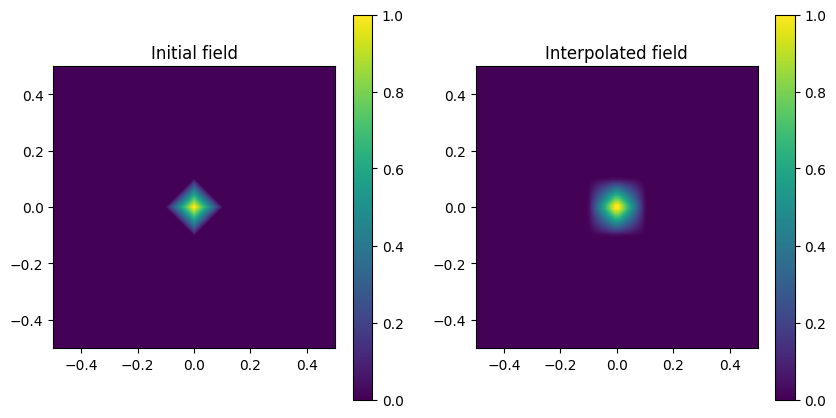

In [59]:
from scipy.interpolate import RegularGridInterpolator
import numpy as np
import matplotlib.pyplot as plt

S = 1 #m
r_d = 0.09
shape = (I, J) = (int(S/r_d), int(S/r_d))
print(f'{shape = }')

field = np.zeros(shape)
field[shape[0]//2, shape[1]//2] = 1
xx = np.linspace(-S/2, S/2, I)
yy = np.linspace(-S/2, S/2, J)
X, Y = np.meshgrid(xx, yy)
print(f'{X.shape = }')
print(f'{Y.shape = }')

# Create an interpolating function
interp_func = RegularGridInterpolator((xx, yy), field, method='linear')

# Define finer resolution
fine_resolution = 100
xx_fine = np.linspace(-S/2, S/2, fine_resolution)
yy_fine = np.linspace(-S/2, S/2, fine_resolution)

# Interpolate the field
X_fine, Y_fine = np.meshgrid(xx_fine, yy_fine)
points_fine = np.array([X_fine.flatten(), Y_fine.flatten()]).T
field_fine = interp_func(points_fine).reshape(fine_resolution, fine_resolution)

print(interp_func([0.01, 0]))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].contourf(X, Y, field, levels=100)
ax[0].set_aspect('equal', adjustable='box')
fig.colorbar(ax[0].collections[0], ax=ax[0])
ax[0].set_title('Initial field')

ax[1].contourf(X_fine, Y_fine, field_fine, levels=100)
ax[1].set_aspect('equal', adjustable='box')
fig.colorbar(ax[1].collections[0], ax=ax[1])
ax[1].set_title('Interpolated field')

plt.show()

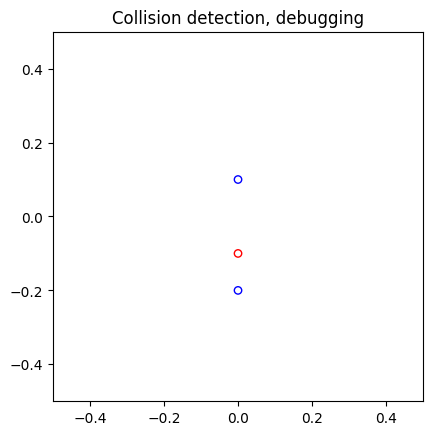

indices = [0, 1]
[(array([ 0. , -0.2]), 0.01), (array([0. , 0.1]), 0.01), (array([ 0. , -0.1]), 0.01)]
[(array([ 0. , -0.2]), 0.01), (array([0. , 0.1]), 0.01)]
[False False]
no collision
1


: 

In [41]:
from plant import Plant

def check_pos_collision(pos, plant):
    return np.sum((pos - plant.pos) ** 2) < plant.r ** 2

plant_kwargs = {
    'r_min': 0.01,
    'r_max': 30,
    'growth_rate': 0.01,
    'reproduction_range': 100,
    'reproduction_chance': 0.025,
}



plants = [Plant(np.array([0, -0.2]), **plant_kwargs), Plant(np.array([0, 0.1]), **plant_kwargs), Plant(np.array([0.0, -0.1]), **plant_kwargs)]
this_plant = plants[-1]

fig, ax = plt.subplots()
for plant in plants:
    ec = 'r' if plant == this_plant else 'b'
    circle = plt.Circle(plant.pos, plant.r, edgecolor=ec, facecolor='none')
    ax.add_patch(circle)
ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-0.5, 0.5)
ax.set_aspect('equal', 'box')
plt.title('Collision detection, debugging')
plt.show()

indices = [j for j, other in enumerate(plants) if other != this_plant]
print(f'{indices = }')
plants_nearby = [plants[i] for i in indices]
print([(plant.pos, plant.r) for plant in plants])
print([(plant.pos, plant.r) for plant in plants_nearby])

collisions_nearby = np.array([check_pos_collision(this_plant.pos, plant) for plant in plants_nearby])
print(collisions_nearby)

p = None
if len(plants_nearby) == 0:
    p =  0
elif collisions_nearby.any():
    print('collision')
    p =  0
else:
    print('no collision')
    p = 1
    
print(p)

seed = 733
1 m = 0.0001414213562373095 u
1 u = 7071.067811865475 m
Iteration 0
P: 10000
density: 0.5423536497915024


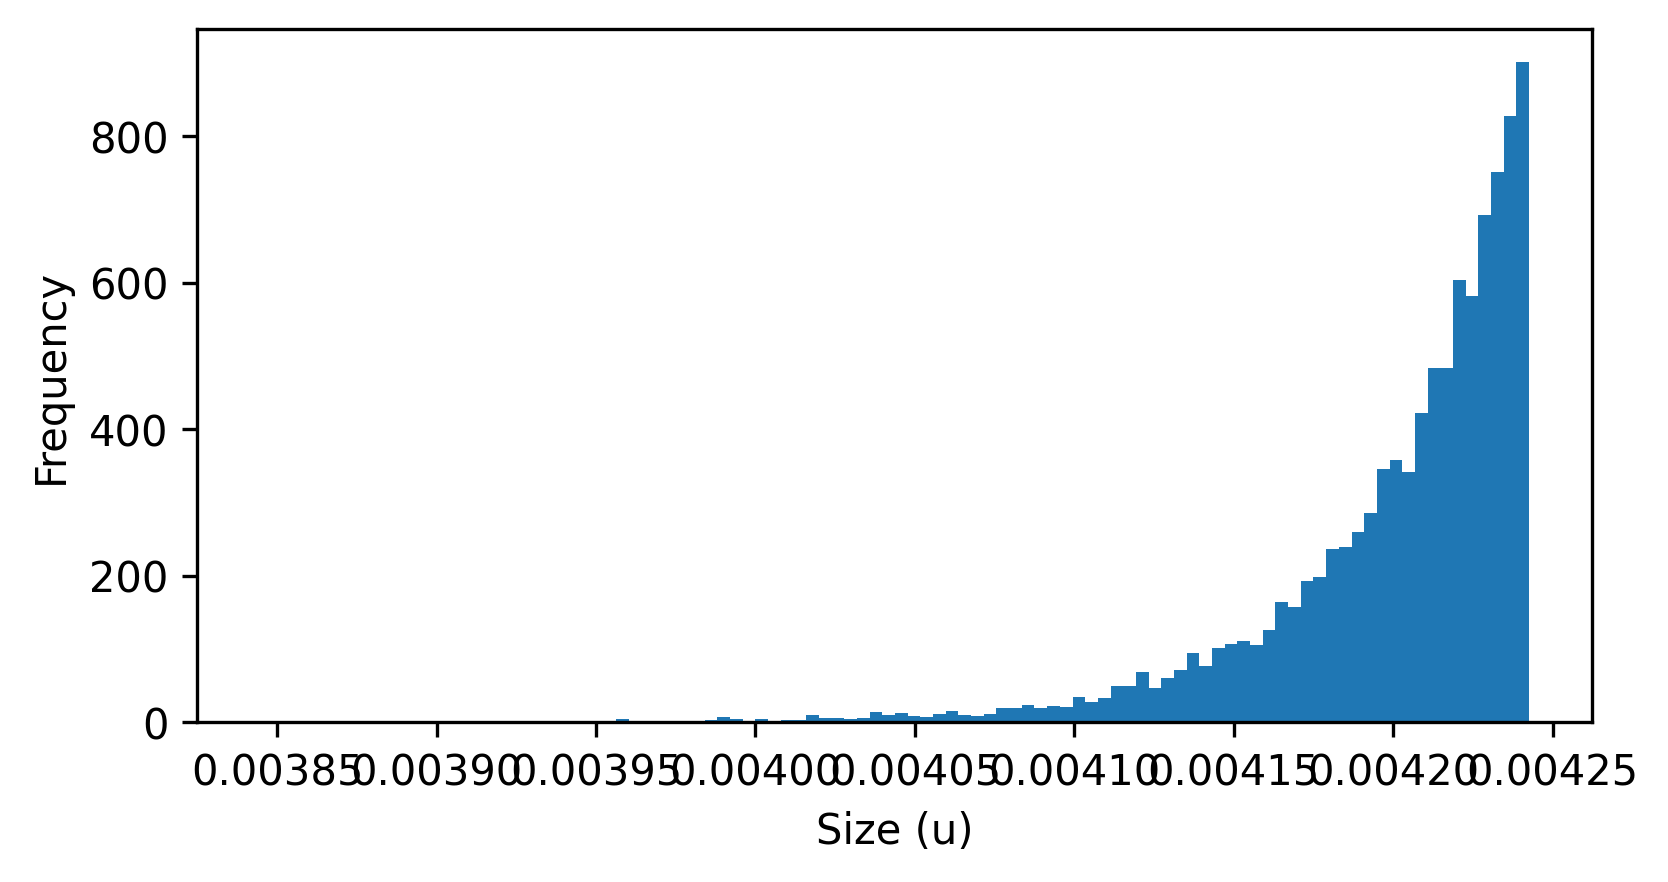

Iteration 1
P: 2755
density: 0.08839619193426237


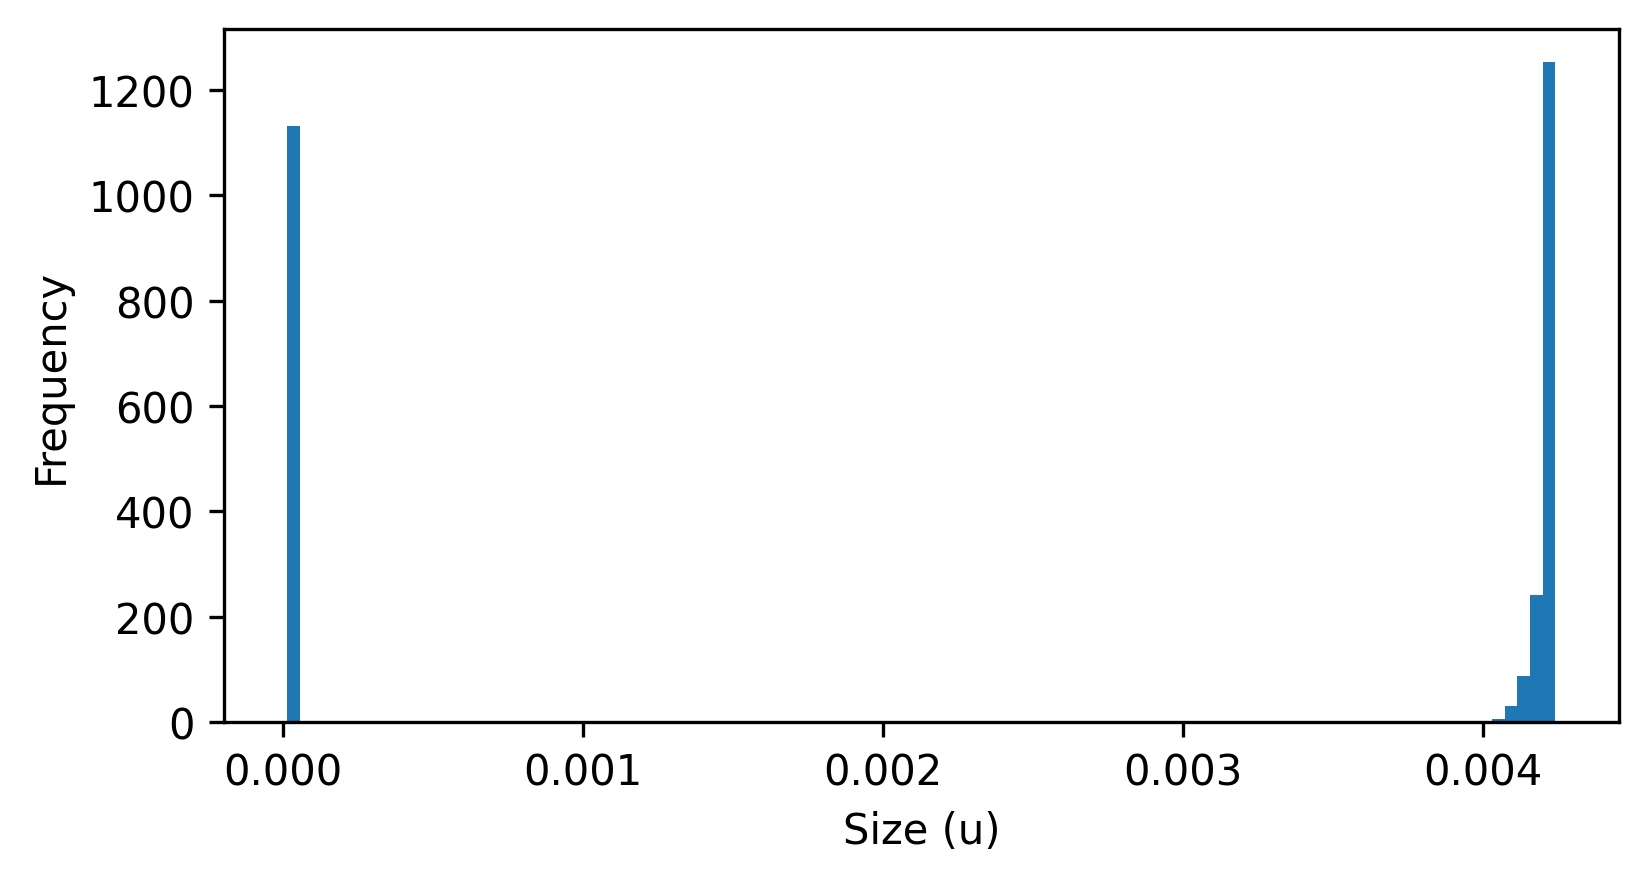

Iteration 11
P: 1113
density: 0.0017242900592535203


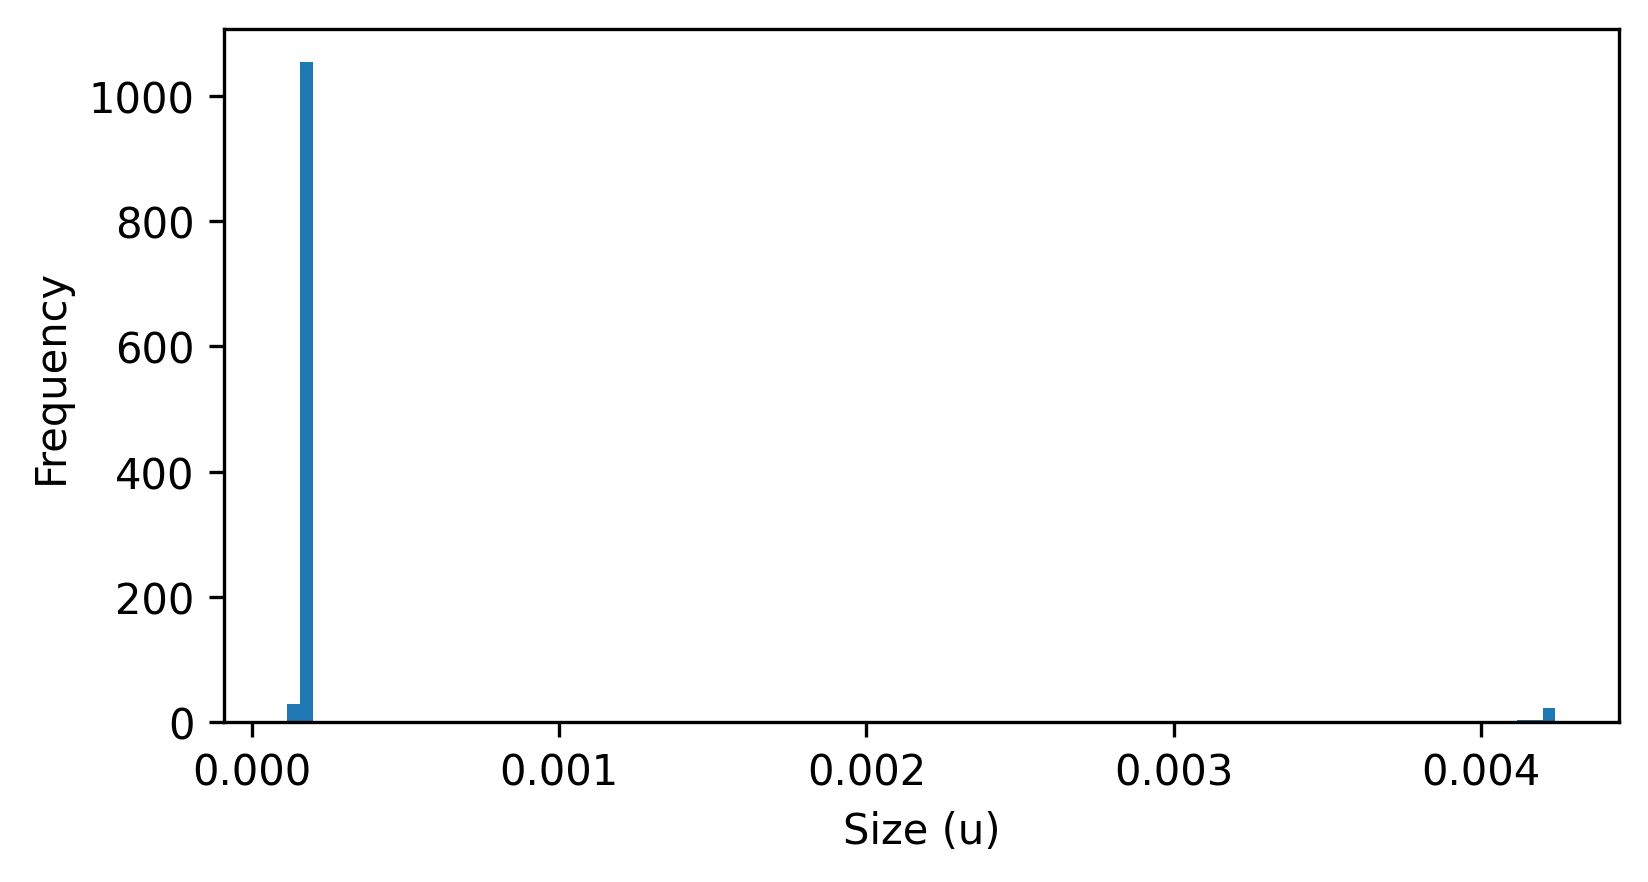

Iteration 21
P: 1078
density: 0.000295004326


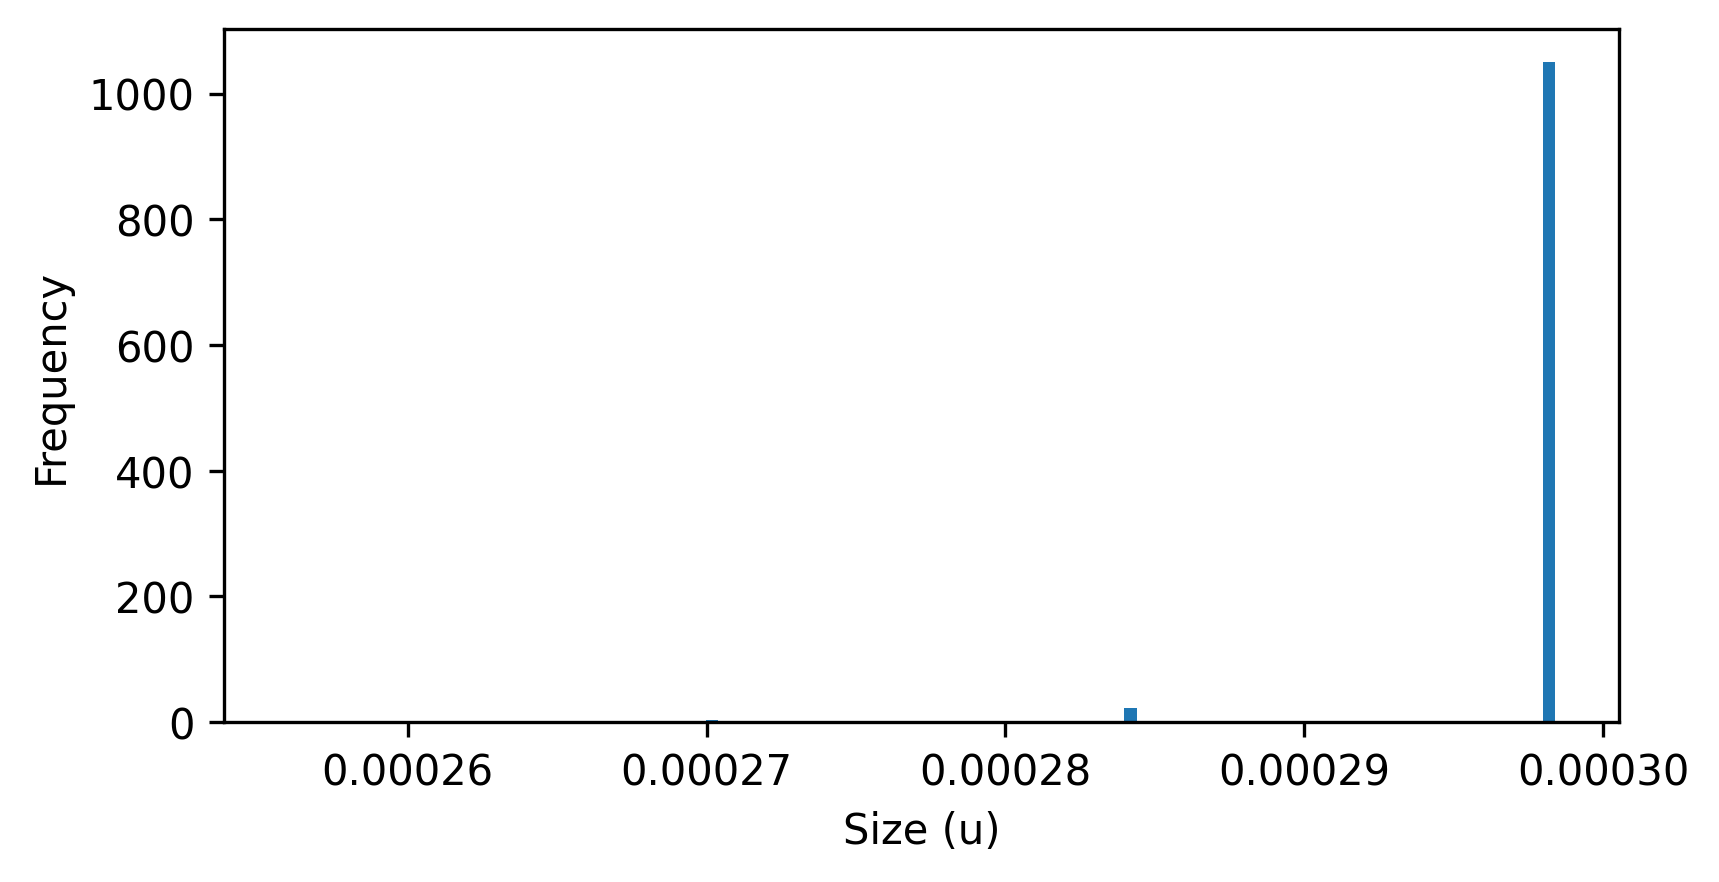

In [15]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

from plant import Plant
from simulation import Simulation

def check_pos_collision(pos, plant):
    return np.sum((pos - plant.pos) ** 2) < plant.r ** 2

seed = np.random.randint(0, 1_000)
np.random.seed(seed)
print(f'{seed = }')

num_plants = 10_000
n_iter = 10_0

half_width = half_height = 0.5
A_bound = 2 * half_width * 2 * half_height

m2pp = m2_per_plant = 5000  # m2/plant
_m = np.sqrt(A_bound/(m2pp*num_plants))
print(f'1 m = {_m} u')
print(f'1 u = {1/_m} m')

# Initialize simulation
plant_kwargs = {
    'r_min': 0.01 * _m,
    'r_max': 30 * _m,
    'growth_rate': 0.1 * _m,
    'reproduction_range': 100 * _m,
    'reproduction_chance': 0.2
    # 'reproduction_thresholds': (0.12, 0.125),
}

sim_kwargs = {
    'seed': seed,
    'half_width': half_width,
    'half_height': half_height,
    'num_plants': num_plants,
    'kt_leafsize': 10,
    'land_quality': -0.1,
    'density_check_radius': 100 * _m,
    'density_check_resolution': 100,
}

sim = Simulation(**sim_kwargs)

d = 100
dist_min = plant_kwargs['r_min']**d
dist_max = plant_kwargs['r_max']**d
plants = [
    Plant(
        pos=np.random.uniform(-half_width, half_width, 2),
        # r=sample_radii_uniform_area(
        #     plant_kwargs['r_min'], plant_kwargs['r_max']),
        # r=np.random.uniform(plant_kwargs['r_min'], plant_kwargs['r_max']),
        r=np.random.uniform(dist_min, dist_max)**(1/d),
        **plant_kwargs
    )
    for _ in range(num_plants)
]

sim.add(plants)
sim.update_kdtree()
sim.update_density_field()



print(f'Iteration {0}')
state = sim.get_state()
density_field = sim.get_density_field()
print('P:' , len(state))
print('density:', np.sum(density_field.values)/(density_field.shape[0] * density_field.shape[1]))

sizes = [plant.r for plant in state]

fig, ax = plt.subplots(1, 1, figsize=(6, 3), dpi = 300)
ax.set_xlabel('Size (u)')
ax.set_ylabel('Frequency')
ax.hist(sizes, bins=100)
plt.show()

for i in range(30):
    sim.step()
    if i % 10 == 0:
        state = sim.get_state()
        density_field = sim.get_density_field()
        print(f'Iteration {i+1}')
        print('P:' , len(state))
        print('density:', np.sum(density_field.values)/(density_field.shape[0] * density_field.shape[1]))
        
        sizes = [plant.r for plant in state]
        
        fig, ax = plt.subplots(1, 1, figsize=(6, 3), dpi = 300)
        ax.set_xlabel('Size (u)')
        ax.set_ylabel('Frequency')
        ax.hist(sizes, bins=100)
        plt.show()

In [43]:
-0.1 + (-1e-4)*1693

-0.2693

In [ ]:
# fig, ax = plt.subplots(1, 3, figsize=(12, 4))
# fig.tight_layout(pad=3.0)

# ax[0].set_xlim(-half_width, half_width)
# ax[0].set_ylim(-half_height, half_height)
# ax[0].set_aspect('equal', 'box')
# ax[0].set_xlabel('Width (u)')
# ax[0].set_ylabel('Height (u)')

# sizes = []
# for plant in state:
#     sizes.append(plant.r)
#     circle = plt.Circle(plant.pos, plant.r, color='green',
#                         fill=True, transform=ax[0].transData)
#     ax[0].add_patch(circle)

# ax[1].set_xlabel('Size ($u$)')
# ax[1].set_ylabel('Frequency')
# ax[1].set_xlim(0, plant_kwargs['r_max'])
# ax[1].set_ylim(0, num_plants)

# bins1 = np.linspace(0, plant_kwargs['r_max'], 25)
# sizes = np.array(sizes)
# ax[1].hist(sizes, bins=bins1, color='black')

# ax[2].set_xlabel('Area ($u^2$)')
# ax[2].set_ylabel('Frequency')
# ax[2].set_xlim(0, np.pi * plant_kwargs['r_max']**2)
# ax[2].set_ylim(0, num_plants)

# bins2 = np.linspace(0, np.pi * plant_kwargs['r_max']**2, 25)
# areas = np.pi * sizes**2
# ax[2].hist(areas, bins=bins2, color='green', alpha=0.5)
# plt.show()